# Question A3

Find the optimal number of hidden neurons for first hidden layer of the 4-layer network (3 hidden layers, output layer) designed in Question 1 and 2

#### Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}. Continue using 5-fold cross validation on training dataset. Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

This might take a while to run, approximately 20 - 30 min, so plan your time carefully.

1. Firstly, we import relevant libraries.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from common_utils import set_seed

# setting seed
set_seed()

2. To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [2]:
# YOUR CODE HERE
# supposed to use cross-validation to find the optimal number of hidden neurons
from common_utils import generate_cv_folds_for_batch_sizes, CustomDataset, preprocess_dataset, split_dataset

def preprocess(df):
    # YOUR CODE HERE
    
    X_train, y_train, X_test, y_test = split_dataset(df, 'filename', 0.30, 1)
    X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)
    
    return X_train_scaled, y_train, X_test_scaled, y_test

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

df['label'].value_counts()

X_train, y_train, X_test, y_test = preprocess(df)

class FirstHiddenLayerMLP(nn.Module):

    def __init__(self, no_features, no_hidden_first_layer, no_labels):
        super().__init__()
        self.mlp_stack = nn.Sequential(
            # YOUR CODE HERE
            nn.Linear(no_features, no_hidden_first_layer),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(no_hidden_first_layer, 128),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(128, no_labels),
            nn.Sigmoid()
        )

    # YOUR CODE HERE
    def forward(self, x):
         logits = self.mlp_stack(x)
         return logits
    
class BatchCustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
def intialise_loaders_batch(X_train_scaled, y_train, X_test_scaled, y_test, batch_size):

#     print("X_train_scaled in initialise loaders batch")
#     print(len(X_train_scaled[0]))
    train_data = BatchCustomDataset(X_train_scaled,y_train)
#     print(len(train_data[1]))
    test_data = BatchCustomDataset(X_test_scaled,y_test)
    
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
    
    return train_dataloader, test_dataloader

def train_loop_batch(dataloader, model, loss_fn, optimizer, x_test, y_test):
    # put within the epochs loop
#     size = len(dataloader.dataset)
#     num_batches = len(dataloader)
#     print(size)
#     print(num_batches)
#     train_loss, train_correct = 0, 0
    acc_ = []
#     print
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
#         print(len(X[0]))
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#         print(len(x_test[0]))
        pred = model(torch.tensor(x_test, dtype=torch.float))
#         print(pred)
#         print(y_test)
#         acc__ = (pred.argmax(1) == torch.tensor(y_test, dtype=torch.float).argmax(1)).type(torch.float).mean()
        acc__ = (pred.argmax(1) == torch.tensor(y_test, dtype=torch.float)).type(torch.float).mean()
        
        acc_.append(acc__.item())
        
    return acc_

3. Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [3]:
def train(model, X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size):

    # YOUR CODE HERE
    
    epochs = 100
    times = []
    train_dataloader, test_dataloader = intialise_loaders(X_train_scaled, y_train2, X_val_scaled, y_val2)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()

    tr_loss, tr_correct = [], []
    te_loss, te_correct = [], []
    for t in range(epochs):
        train_loss, train_correct = train_loop(train_dataloader, model, loss_fn, optimizer)
        test_loss, test_correct = test_loop(test_dataloader, model, loss_fn)

        tr_loss.append(train_loss), tr_correct.append(train_correct)
        te_loss.append(test_loss), te_correct.append(test_correct)
        times.append(t+1)
        
        print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")
        
    train_accuracies = tr_correct
    train_losses = tr_loss
    test_accuracies = te_correct
    test_losses = te_loss

    return train_accuracies, train_losses, test_accuracies, test_losses, times

In [4]:
def find_optimal_hyperparameter(X_train, y_train, parameters, mode, batch_size):

    # YOUR CODE HERE
    # can ignore mode in the find_optimal_hyperparameter function
    
    # put generate cv folds for batch sizes here, returns X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict
    # so now we are only passing in one batch size, so each dict should be of size 1*5
    X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_cv_folds_for_batch_sizes(batch_size,X_train,y_train)
#     print(len(X_train_scaled_dict))
#     print(len(X_train_scaled_dict[1024]))
#     print(len(X_val_scaled_dict))
#     print(len(X_val_scaled_dict[1024]))
#     print(len(y_train_dict))
#     print(len(y_train_dict[1024]))
#     print(len(y_val_dict))
#     print(len(y_val_dict[1024]))

    cross_validation_times = []
#     acc = []
    foldaccuracyofabatchsize = []
    timeforafoldforthatbatchsize = []
    meanaccuracyofabatchsizelist = []
    meantimeofabatchsizelist = []
    for no_neurons in parameters:
        print("neurons " + str(no_neurons))
        model = FirstHiddenLayerMLP(77,no_neurons,2)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        loss_fn = nn.CrossEntropyLoss()
        print(foldaccuracyofabatchsize)
        print(timeforafoldforthatbatchsize)
        foldaccuracyofabatchsize = []
        timeforafoldforthatbatchsize = []
        for idxy in range(0,5):
            x_train = X_train_scaled_dict[batch_size[0]][idxy]
            y_train = y_train_dict[batch_size[0]][idxy]
            x_val = X_val_scaled_dict[batch_size[0]][idxy]
            y_val = y_val_dict[batch_size[0]][idxy]
            print(foldaccuracyofabatchsize)
            print(timeforafoldforthatbatchsize)
            train_dataloader, test_dataloader = intialise_loaders_batch(x_train, y_train, x_val, y_val, batch_size[0])

            for epoch in range(100):
                start = time.time()
                acc_ = train_loop_batch(train_dataloader, model, loss_fn, optimizer, x_val, y_val)
                end = time.time()
                    # for a fold, the list of accuracies for the batches of that epoch^
                print("an epoch" + str(epoch))
                if epoch==99:
                    foldaccuracyofabatchsize.append(np.mean(np.array(acc_), axis = 0))
    #                    the accuracy for the last epoch of that fold - the fold accuracy for that batch size, length is 5
                    timeforafoldforthatbatchsize.append(end-start)
        meanaccuracyofabatchsizelist.append(np.mean(np.array(foldaccuracyofabatchsize), axis = 0))
        meantimeofabatchsizelist.append(np.mean(np.array(timeforafoldforthatbatchsize), axis = 0))        


    cross_validation_accuracies = meanaccuracyofabatchsizelist
    cross_validation_times = meantimeofabatchsizelist
    print(cross_validation_accuracies)
    print(cross_validation_times)
    return cross_validation_accuracies, cross_validation_times

'''
optimal_bs = 0. Fill your optimal batch size in the following code.
'''
# YOUR CODE HERE
optimal_bs = [1024]
num_neurons = [64,128,256]
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train, y_train, num_neurons, 'num_neurons', optimal_bs)

neurons 64
[]
[]
[]
[]
an epoch0
an epoch1
an epoch2
an epoch3
an epoch4
an epoch5
an epoch6
an epoch7
an epoch8
an epoch9
an epoch10
an epoch11
an epoch12
an epoch13
an epoch14
an epoch15
an epoch16
an epoch17
an epoch18
an epoch19
an epoch20
an epoch21
an epoch22
an epoch23
an epoch24
an epoch25
an epoch26
an epoch27
an epoch28
an epoch29
an epoch30
an epoch31
an epoch32
an epoch33
an epoch34
an epoch35
an epoch36
an epoch37
an epoch38
an epoch39
an epoch40
an epoch41
an epoch42
an epoch43
an epoch44
an epoch45
an epoch46
an epoch47
an epoch48
an epoch49
an epoch50
an epoch51
an epoch52
an epoch53
an epoch54
an epoch55
an epoch56
an epoch57
an epoch58
an epoch59
an epoch60
an epoch61
an epoch62
an epoch63
an epoch64
an epoch65
an epoch66
an epoch67
an epoch68
an epoch69
an epoch70
an epoch71
an epoch72
an epoch73
an epoch74
an epoch75
an epoch76
an epoch77
an epoch78
an epoch79
an epoch80
an epoch81
an epoch82
an epoch83
an epoch84
an epoch85
an epoch86
an epoch87
an epoch88
an epoch

an epoch97
an epoch98
an epoch99
[0.9992383292743138, 1.0]
[1.1549386978149414, 1.258009910583496]
an epoch0
an epoch1
an epoch2
an epoch3
an epoch4
an epoch5
an epoch6
an epoch7
an epoch8
an epoch9
an epoch10
an epoch11
an epoch12
an epoch13
an epoch14
an epoch15
an epoch16
an epoch17
an epoch18
an epoch19
an epoch20
an epoch21
an epoch22
an epoch23
an epoch24
an epoch25
an epoch26
an epoch27
an epoch28
an epoch29
an epoch30
an epoch31
an epoch32
an epoch33
an epoch34
an epoch35
an epoch36
an epoch37
an epoch38
an epoch39
an epoch40
an epoch41
an epoch42
an epoch43
an epoch44
an epoch45
an epoch46
an epoch47
an epoch48
an epoch49
an epoch50
an epoch51
an epoch52
an epoch53
an epoch54
an epoch55
an epoch56
an epoch57
an epoch58
an epoch59
an epoch60
an epoch61
an epoch62
an epoch63
an epoch64
an epoch65
an epoch66
an epoch67
an epoch68
an epoch69
an epoch70
an epoch71
an epoch72
an epoch73
an epoch74
an epoch75
an epoch76
an epoch77
an epoch78
an epoch79
an epoch80
an epoch81
an epoch8

an epoch91
an epoch92
an epoch93
an epoch94
an epoch95
an epoch96
an epoch97
an epoch98
an epoch99
[0.9996614796774728, 1.0, 1.0, 1.0]
[2.2923264503479004, 1.5584602355957031, 1.600780725479126, 1.6488535404205322]
an epoch0
an epoch1
an epoch2
an epoch3
an epoch4
an epoch5
an epoch6
an epoch7
an epoch8
an epoch9
an epoch10
an epoch11
an epoch12
an epoch13
an epoch14
an epoch15
an epoch16
an epoch17
an epoch18
an epoch19
an epoch20
an epoch21
an epoch22
an epoch23
an epoch24
an epoch25
an epoch26
an epoch27
an epoch28
an epoch29
an epoch30
an epoch31
an epoch32
an epoch33
an epoch34
an epoch35
an epoch36
an epoch37
an epoch38
an epoch39
an epoch40
an epoch41
an epoch42
an epoch43
an epoch44
an epoch45
an epoch46
an epoch47
an epoch48
an epoch49
an epoch50
an epoch51
an epoch52
an epoch53
an epoch54
an epoch55
an epoch56
an epoch57
an epoch58
an epoch59
an epoch60
an epoch61
an epoch62
an epoch63
an epoch64
an epoch65
an epoch66
an epoch67
an epoch68
an epoch69
an epoch70
an epoch71
an 

4. Plot the cross-validation accuracies against the number of epochs for different numbers of hidden-layer neurons. Limit the search space of the number of neurons to {64, 128, 256}.

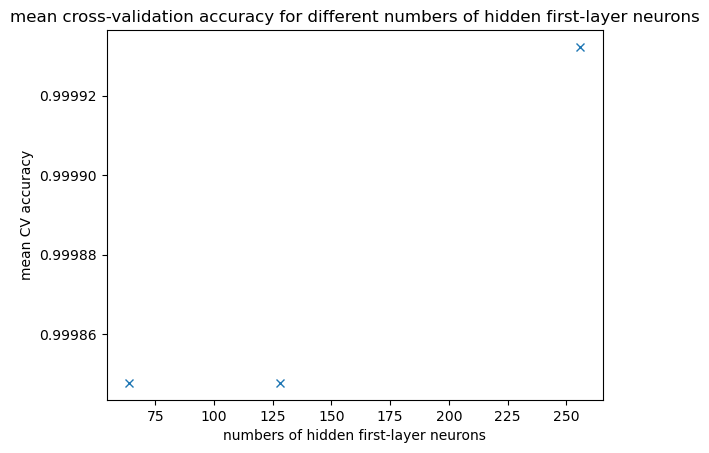

In [5]:
# YOUR CODE HERE
# plot the mean cross-validation accuracies on the final epoch for different numbers of first hidden-layer neurons. You are supposed to plot 1 graph here, similar to the one in Q A2
# The question in Q3 is to plot the mean cross-validation accuracies on the final epoch for different number of first hidden-layer neurons.
plt.plot(num_neurons, cross_validation_accuracies, marker = 'x', linestyle = 'None')
plt.title('mean cross-validation accuracy for different numbers of hidden first-layer neurons')
plt.xlabel('numbers of hidden first-layer neurons')
plt.ylabel('mean CV accuracy')
plt.show()

5. Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

In [6]:
optimal_neurons = 256
reason = "Highest mean CV accuracy"
# YOUR CODE HERE

6. Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.

Epoch 1: Train_accuracy: 59.97%, Train_loss: 0.683324, Test_accuracy: 76.12%, Test_loss: 0.661265
Epoch 2: Train_accuracy: 83.90%, Train_loss: 0.612690, Test_accuracy: 93.26%, Test_loss: 0.532889
Epoch 3: Train_accuracy: 96.15%, Train_loss: 0.450164, Test_accuracy: 98.18%, Test_loss: 0.373180
Epoch 4: Train_accuracy: 98.97%, Train_loss: 0.343190, Test_accuracy: 99.25%, Test_loss: 0.326646
Epoch 5: Train_accuracy: 99.47%, Train_loss: 0.321410, Test_accuracy: 99.72%, Test_loss: 0.317918
Epoch 6: Train_accuracy: 99.79%, Train_loss: 0.316500, Test_accuracy: 99.75%, Test_loss: 0.316003
Epoch 7: Train_accuracy: 99.86%, Train_loss: 0.315390, Test_accuracy: 99.83%, Test_loss: 0.315017
Epoch 8: Train_accuracy: 99.88%, Train_loss: 0.314924, Test_accuracy: 99.94%, Test_loss: 0.314351
Epoch 9: Train_accuracy: 99.92%, Train_loss: 0.314736, Test_accuracy: 99.94%, Test_loss: 0.314086
Epoch 10: Train_accuracy: 99.87%, Train_loss: 0.314738, Test_accuracy: 99.86%, Test_loss: 0.314542
Epoch 11: Train_acc

Epoch 84: Train_accuracy: 99.99%, Train_loss: 0.313367, Test_accuracy: 99.97%, Test_loss: 0.313465
Epoch 85: Train_accuracy: 100.00%, Train_loss: 0.313318, Test_accuracy: 99.97%, Test_loss: 0.313415
Epoch 86: Train_accuracy: 99.99%, Train_loss: 0.313359, Test_accuracy: 99.94%, Test_loss: 0.313820
Epoch 87: Train_accuracy: 99.99%, Train_loss: 0.313400, Test_accuracy: 100.00%, Test_loss: 0.313270
Epoch 88: Train_accuracy: 100.00%, Train_loss: 0.313292, Test_accuracy: 99.97%, Test_loss: 0.313547
Epoch 89: Train_accuracy: 99.89%, Train_loss: 0.314136, Test_accuracy: 99.97%, Test_loss: 0.313468
Epoch 90: Train_accuracy: 99.98%, Train_loss: 0.313540, Test_accuracy: 100.00%, Test_loss: 0.313309
Epoch 91: Train_accuracy: 100.00%, Train_loss: 0.313298, Test_accuracy: 99.94%, Test_loss: 0.313639
Epoch 92: Train_accuracy: 100.00%, Train_loss: 0.313353, Test_accuracy: 100.00%, Test_loss: 0.313330
Epoch 93: Train_accuracy: 99.99%, Train_loss: 0.313367, Test_accuracy: 100.00%, Test_loss: 0.313277
Ep

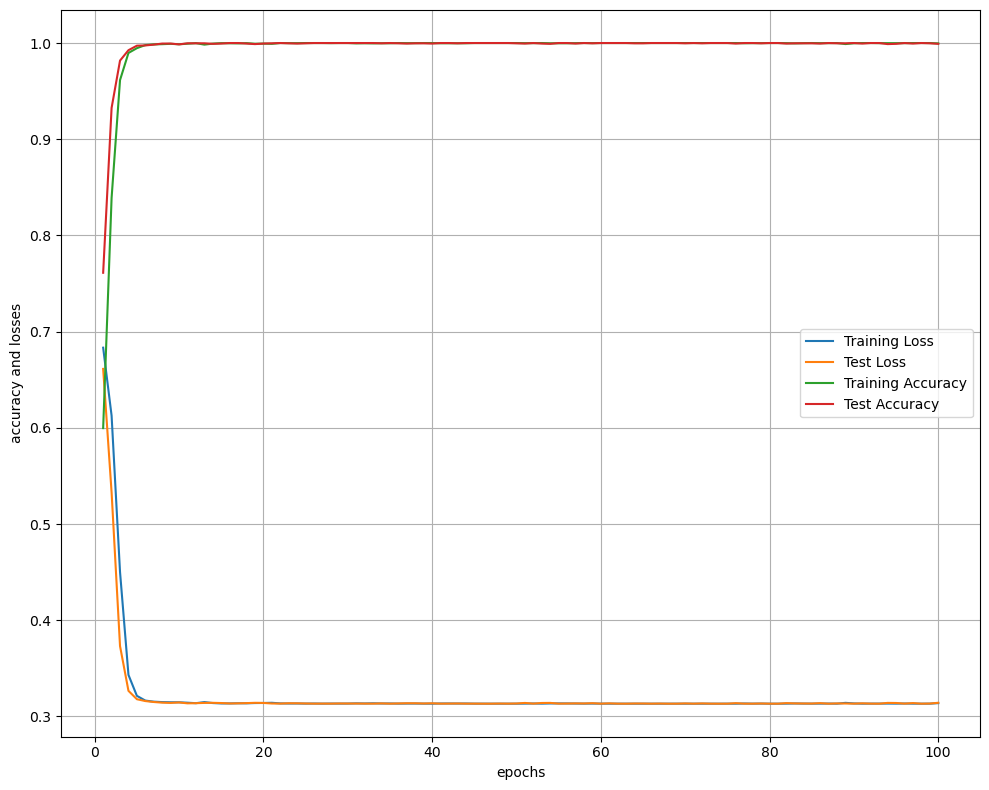

In [7]:
# YOUR CODE HERE
# after k-fold cross validation and when you have selected the optimal hyperparameters, train the model again with the full training dataset and test on the test dataset which is untouched until then.

from common_utils import MLP

def intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test):
    # YOUR CODE HERE
#     train_dataset = CustomDataset(X_train_scaled)
#     test_dataset = CustomDataset(X_test_scaled)
    
#     train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
#     test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

    train_data = CustomDataset(X_train_scaled,y_train)
    test_data = CustomDataset(X_test_scaled,y_test)
    
    train_dataloader = DataLoader(train_data, batch_size=1024, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=1024, shuffle=True)
    
    return train_dataloader, test_dataloader

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    train_loss /= num_batches
    train_correct /=size

    return train_loss, train_correct

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            test_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    test_correct /= size
    
    return test_loss, test_correct

model = FirstHiddenLayerMLP(77,256,2)
train_accuracies, train_losses, test_accuracies, test_losses, times = train(model, X_train, y_train, X_test, y_test, 1024)

fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_losses)+1),train_losses, label='Training Loss')
plt.plot(range(1,len(test_losses)+1),test_losses,label='Test Loss')
plt.plot(range(1,len(train_accuracies)+1),train_accuracies,label='Training Accuracy')
plt.plot(range(1,len(test_accuracies)+1),test_accuracies,label='Test Accuracy')

plt.xlabel('epochs')
plt.ylabel('accuracy and losses')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()